In [17]:
### imports

# external modules
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import importlib
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model, Sequential, load_model
import importlib
from sklearn.preprocessing import StandardScaler

# local modules
sys.path.append('../utils')
import csv_utils as csvu
import json_utils as jsonu
import dataframe_utils as dfu
import hist_utils as hu
import autoencoder_utils as aeu
import plot_utils as pu
import generate_data_utils as gdu
import refruns_utils as rru
importlib.reload(csvu)
importlib.reload(jsonu)
importlib.reload(dfu)
importlib.reload(hu)
importlib.reload(aeu)
importlib.reload(pu)
importlib.reload(gdu)
importlib.reload(rru)
sys.path.append('../src')
sys.path.append('../src/classifiers')
sys.path.append('../src/cloudfitters')
import HistStruct
importlib.reload(HistStruct)
import SubHistStruct
importlib.reload(SubHistStruct)
import DataLoader
importlib.reload(DataLoader)
import AutoEncoder
importlib.reload(AutoEncoder)
import SeminormalFitter
import GaussianKdeFitter
import HyperRectangleFitter
importlib.reload(SeminormalFitter)
importlib.reload(GaussianKdeFitter)
importlib.reload(HyperRectangleFitter)

<module 'HyperRectangleFitter' from '/eos/home-i01/k/khowey/SWAN_projects/ML4DQMDC-PixelAE/KH-AutoencoderTest/../src/cloudfitters/HyperRectangleFitter.py'>

In [2]:
### Speed Controls and Run Mode

# Disables all plots for large datasets where speed is more important
createPlots = True

# Control for the notebook - turn off user-friendly mode to enable faster runtimes
userfriendly = True

In [40]:
### Evaluation Parameters

# Select the bias towards recall against precision, treated as a factor (so < 1 biases towards precision, 1 is equal importance, and > 1 biases towards recall)
wpBiasFactor = 20
fmBiasFactor = 2

In [43]:
### Data Controls and Selection - 1D Autoncoder

# The directory data is located in
datadir = '../data/'

# Select a list of good runs to train on in development training_mode
# Should be validated by eye
trainrunsls = {'2017B':{
#                    "297057":[[-1]], 
#                    "297099":[[-1]], 
#                    "297101":[[-1]],
#                    "297113":[[-1]], 
#                    "297114":[[-1]], 
                    "297175":[[-1]],   # A decently clean histogram
#                    "297177":[[-1]],
#                    "297179":[[-1]], 
#                    "297215":[[-1]],
#                    "297218":[[-1]],
#                    "297225":[[-1]],
#                    "297296":[[-1]], 
#                    "297411":[[-1]],
#                    "297426":[[-1]],  
#                    "297431":[[-1]],
#                    "297434":[[-1]], 
#                    "297468":[[-1]],
#                    "297483":[[-1]],
#                    "297486":[[-1]],
#                    "297503":[[-1]],
#                    "297557":[[-1]],
#                   "297598":[[-1]],
#                   "297604":[[-1]],   # A decently clean histogram
                   "297620":[[-1]],   # A decently clean histogram
                   "297659":[[-1]],   # An okay histogram
                   "297670":[[-1]],   # A decently clean histogram
#                    "297674":[[-1]],
#                    "297678":[[-1]],   # A particularly messy histogram
#                    "297722":[[-1]],   # A decently clean histogram
#                    "298997":[[-1]],
#                    "299061":[[-1]],
                   "299065":[[-1]],   # A decently clean histogram
                   "299067":[[-1]],   # A decently clean histogram
                   "299096":[[-1]],
                   "299149":[[-1]],
#                    "299178":[[-1]],   # A decently clean histogram
#                    "299184":[[-1]],   # A particularly messy histogram
#                    "299185":[[-1]],   # A decently clean histogram
#                    "299327":[[-1]],
#                    "299329":[[-1]], 
#                    "299480":[[-1]]    # A decently clean histogram
                    },
                   '2017C': {
                      "299370":[[-1]],
                      "299394":[[-1]],
                      "299420":[[-1]],
                      "299477":[[-1]],
                      "299593":[[-1]],
                      "299597":[[-1]],
                      "299617":[[-1]],
                      "300018":[[-1]],
                      "300105":[[-1]],
                      "300117":[[-1]],
                      "300124":[[-1]],
                      "300234":[[-1]],
                      "300237":[[-1]],
                      "300240":[[-1]],
                      "300370":[[-1]],
                      "300157":[[-1]],
                      "300373":[[-1]],
                      "300392":[[-1]],
                      "300395":[[-1]],
                      "300401":[[-1]],
                      "300462":[[-1]],
                      "300466":[[-1]],
                      "300514":[[-1]],
                      "300517":[[-1]],
                      "300538":[[-1]],
                      "300539":[[-1]],
                      "300364":[[-1]],
                 },'2017F':{
                      "305310":[[-1]],
                      "305040":[[-1]],
                      "305043":[[-1]],
                      "305185":[[-1]],
                      "305204":[[-1]],
                      "305234":[[-1]],
                      "305247":[[-1]],
                      "305313":[[-1]],
                      "305338":[[-1]],
                      "305350":[[-1]],
                      "305364":[[-1]],
                      "305376":[[-1]],
                      "306042":[[-1]],
                      "306051":[[-1]],
                      "305406":[[-1]],
                      "306122":[[-1]],
                      "306134":[[-1]],
                      "306137":[[-1]],
                      "306154":[[-1]],
                      "306170":[[-1]],
                      "306417":[[-1]],
                      "306432":[[-1]],
                      "306456":[[-1]],
                      "305516":[[-1]],
                      "305586":[[-1]],
                      "305588":[[-1]],
                      "305590":[[-1]],
                      "305809":[[-1]],
                      "305832":[[-1]],
                      "305840":[[-1]],
                      "305898":[[-1]],
                      "306029":[[-1]],
                      "306037":[[-1]],
                      "306095":[[-1]],
                },
                '2018':{ # needs to be re-checked, not guaranteed to be fully correct or representative.   
                  "315267":[[-1]] 
              }
}

# Select a list of good runs to test on in development training_mode
# Should be validated by eye
goodrunsls = {'2017B':{
#                    "297057":[[-1]], 
#                    "297099":[[-1]], 
#                    "297101":[[-1]],
#                    "297113":[[-1]], 
#                    "297114":[[-1]], 
                    "297175":[[-1]],   # A decently clean histogram
#                    "297177":[[-1]],
#                    "297179":[[-1]], 
#                    "297215":[[-1]],
#                    "297218":[[-1]],
#                    "297225":[[-1]],
#                    "297296":[[-1]], 
#                    "297411":[[-1]],
#                    "297426":[[-1]],  
#                    "297431":[[-1]],
#                    "297434":[[-1]], 
#                    "297468":[[-1]],
#                    "297483":[[-1]],
#                    "297486":[[-1]],
#                    "297503":[[-1]],
#                    "297557":[[-1]],
#                    "297598":[[-1]],
#                    "297604":[[-1]],   # A decently clean histogram
#                    "297620":[[-1]],   # A decently clean histogram
                    "297659":[[-1]],   # An okay histogram
                    "297670":[[-1]],   # A decently clean histogram
                    "297674":[[-1]],
#                    "297678":[[-1]],   # A particularly messy histogram
                    "297722":[[-1]],   # A decently clean histogram
#                    "298997":[[-1]],
#                    "299061":[[-1]],
                    "299065":[[-1]],   # A decently clean histogram
                    "299067":[[-1]],   # A decently clean histogram
#                    "299096":[[-1]],
#                    "299149":[[-1]],
#                    "299178":[[-1]],   # A decently clean histogram
#                    "299184":[[-1]],   # A particularly messy histogram
                    "299185":[[-1]],   # A decently clean histogram
                    "299327":[[-1]],
#                    "299329":[[-1]], 
                    "299480":[[-1]]    # A decently clean histogram
                    },
                '2017C':{
                      "299370":[[-1]],
                      "299394":[[-1]],
                      "299420":[[-1]],
                      "299477":[[-1]],
                      "299593":[[-1]],
                      "299597":[[-1]],
                      "299617":[[-1]],
                      "300018":[[-1]],
                      "300105":[[-1]],
                      "300117":[[-1]],
                      "300124":[[-1]],
                      "300234":[[-1]],
                      "300237":[[-1]],
                      "300240":[[-1]],
                      "300370":[[-1]],
                      "300157":[[-1]],
                      "300373":[[-1]],
                      "300392":[[-1]],
                      "300395":[[-1]],
                      "300401":[[-1]],
                      "300462":[[-1]],
                      "300466":[[-1]],
                      "300514":[[-1]],
                      "300517":[[-1]],
                      "300538":[[-1]],
                      "300539":[[-1]],
                      "300364":[[-1]],
                },'2017F':{
                      "305310":[[-1]],
                      "305040":[[-1]],
                      "305043":[[-1]],
                      "305185":[[-1]],
                      "305204":[[-1]],
                      "305234":[[-1]],
                      "305247":[[-1]],
                      "305313":[[-1]],
                      "305338":[[-1]],
                      "305350":[[-1]],
                      "305364":[[-1]],
                      "305376":[[-1]],
                      "306042":[[-1]],
                      "306051":[[-1]],
                      "305406":[[-1]],
                      "306122":[[-1]],
                      "306134":[[-1]],
                      "306137":[[-1]],
                      "306154":[[-1]],
                      "306170":[[-1]],
                      "306417":[[-1]],
                      "306432":[[-1]],
                      "306456":[[-1]],
                      "305516":[[-1]],
                      "305586":[[-1]],
                      "305588":[[-1]],
                      "305590":[[-1]],
                      "305809":[[-1]],
                      "305832":[[-1]],
                      "305840":[[-1]],
                      "305898":[[-1]],
                      "306029":[[-1]],
                      "306037":[[-1]],
                      "306095":[[-1]],
                },
                '2018':{ # needs to be re-checked, not guaranteed to be fully correct or representative.   
                  "315267":[[-1]] 
              }
}


badrunsls = {'2017B':
                {
                    #"297048":[[-1]],
                    #"297282":[[-1]],
                    #"297283":[[-1]],
                    #"297284":[[-1]],
                    #"297287":[[-1]],
                    #"297288":[[-1]],
                    #"297289":[[-1]],
                    "299316":[[-1]],
                    "299317":[[-1]],
                    "299318":[[-1]],
                    "299324":[[-1]],
                    "299326":[[-1]],
                    #"301086":[[88,126]],
                    #"301086":[[89,89]],
                    #"303948":[[1710,1710]],
                    "297047":[[-1]], #close but, true bad for all 8
                    "297169":[[-1]], #true bad for all 8
#                   "297211":[[-1]], #Reconstructs well
#                   "299325":[[-1]], #Reconstructs well
                    "297664":[[-1]], #true bad for all 8
                    "299317":[[-1]], #true bad for all 8
                    "297169":[[-1]], #true bad for all 8
#                   "297502":[[-1]]
                },
             '2017C':{
#                 "300781":[[-1]], # bad for tracking (pixels were excluded.
                 "300079":[[-1]], # is bad for strips and then also for tracking
#                 "302029":[[-1]], # Poor detector elements for strips - Should be mildly anomalous, but technically good 
#                 "300576":[[-1]], # Poor detector elements for strips - Should be mildly anomalous, but technically good
#                 "300574":[[-1]], # Poor detector elements for strips - Should be mildly anomalous, but technically good
#                 "300282":[[-1]], # Poor detector elements for strips - Should be mildly anomalous, but technically good
#                 "301912":[[-1]], # Half bad for pixels (lost HV or readout card)  
#                 "301086":[[-1]], # Half bad for pixels (lost HV or readout card)  
#                 "300283":[[-1]], # Half bad for pixels (lost HV or readout card) 
                 "300282":[[-1]], # Half bad for pixels (lost HV or readout card) 
#                 "300281":[[-1]], # Half bad for pixels (lost HV or readout card) 
#                 "300239":[[-1]], # Half bad for pixels (lost HV or readout card)
#                 "301394":[[-1]], # Marginal for pixels
#                 "301183":[[-1]], # Marginal for pixels
                 "300398":[[-1]], # Marginal for pixels
                 "300389":[[-1]], # Marginal for pixels
#                 "300365":[[-1]]  # Marginal for pixels
              },
             '2017E':{
                 "304740":[[-1]], # Bad for pixels and tracking - holes in PXLayer 1
                 "304776":[[-1]], # Bad for pixels and tracking - holes in PXLayer 1
                 "304506":[[-1]], # Portcard problem for pixels
                 "304507":[[-1]], # Portcard problem for pixels 
                 "303989":[[-1]], # Bad for pixels, power supply died
                 "303824":[[-1]]  # Partly bad for strips due to a test
             },
             '2017F':{
                 "306422":[[-1]], # Partly bad for strips - 2 data readouts failed 
#                 "306423":[[-1]], # Partly bad for strips - 2 data readouts failed
#                 "306425":[[-1]], # Partly bad for strips - 2 data readouts failed
#                 "305440":[[-1]], # Partly bad for strips - 1 data readout failed
#                 "305441":[[-1]], # Partly bad for strips - 1 data readout failed
                 "305249":[[-1]], # Bad for pixels - half of disk failed 
                 "305250":[[-1]], # Bad for pixels - half of disk failed
#                 "305064":[[-1]], # Marginal for pixels - some readout failed
             },
            '2018': # needs to be re-checked, not guaranteed to be fully correct or representative.
                {
                #"317479":[[-1]],
                "317480":[[-1]],
                "317481":[[-1]],
                "317482":[[-1]],
                #"319847":[[1,35]]
            }}


# The year and era being used
year = '2017'
era = 'B'

# Create a list of histograms to include
# Pair histograms to be combined on the same line
histnames = [
    ['NormalizedHitResiduals_TIB__Layer__1', 'Summary_ClusterStoNCorr__OnTrack__TIB__layer__1', 'NormalizedHitResiduals_TIB__Layer__2', 'Summary_ClusterStoNCorr__OnTrack__TIB__layer__2',
     'NormalizedHitResiduals_TIB__Layer__3', 'Summary_ClusterStoNCorr__OnTrack__TIB__layer__3' , 'NormalizedHitResiduals_TIB__Layer__4', 'Summary_ClusterStoNCorr__OnTrack__TIB__layer__4'],
    ['chargeInner_PXLayer_1', 'chargeOuter_PXLayer_1', 'adc_PXLayer_1', 'size_PXLayer_1'],
    ['chargeInner_PXLayer_2', 'chargeOuter_PXLayer_2', 'adc_PXLayer_2', 'size_PXLayer_2'],
    ['chargeInner_PXLayer_3', 'chargeOuter_PXLayer_3', 'adc_PXLayer_3', 'size_PXLayer_3'],
    ['chargeInner_PXLayer_4', 'chargeOuter_PXLayer_4', 'adc_PXLayer_4', 'size_PXLayer_4'],
    ['charge_PXDisk_+1', 'adc_PXDisk_+1'],
    ['charge_PXDisk_-1', 'adc_PXDisk_-1'],
    ['charge_PXDisk_+2', 'adc_PXDisk_+2'],
    ['charge_PXDisk_-2', 'adc_PXDisk_-2'],
    ['charge_PXDisk_+3', 'adc_PXDisk_+3'],
    ['charge_PXDisk_-3', 'adc_PXDisk_-3'],
    ['NormalizedHitResiduals_TOB__Layer__1', 'Summary_ClusterStoNCorr__OnTrack__TOB__layer__1', 'NormalizedHitResiduals_TOB__Layer__2', 'Summary_ClusterStoNCorr__OnTrack__TOB__layer__2',
     'NormalizedHitResiduals_TOB__Layer__3', 'Summary_ClusterStoNCorr__OnTrack__TOB__layer__3' , 'NormalizedHitResiduals_TOB__Layer__4', 'Summary_ClusterStoNCorr__OnTrack__TOB__layer__4']
]

# Read new data or use previously saved data & should data be saved
readnew = True
save = False

In [44]:
### Define Run Properties - Combined Autoencoder
# in this cell all major run properties are going to be set,

# Set whether to train globally or locally or in a development/testing mode
training_mode = 'development'

# Selects whether to create a new histstruct or use a saved one
readnew = True

# Select whether to save a new histstruct
save = False

In [45]:
### Model Controls and Selection - 1D Autoencoder

plotNames = 'Test'
name = plotNames+'plots'

# Choose whether to train a new model or load one
trainnew = True
savemodel = True
modelname = plotNames

# Evaluate models seperately, as an ensemble, both, or neither
individualEval = True
ensembleEval = False

In [46]:
### Define Training Mode Parameters - Combined Autoencoder
if training_mode == 'global':
    runsls_training = None # use none to not add a mask for training (can e.g. use DCS-bit on mask)
    runsls_good = None # use none to not add a mask for good runs (can e.g. use averages of training set)
    runsls_bad = badrunsls[year] # predefined bad runs
    print('selected runs/lumisections for training: all')
    
elif training_mode == 'local':
    # train locally on a small set of runs
    # - either on n runs preceding a chosen application run,
    # - or on the run associated as reference to the chosen application run.
    # - this only works for a single era
    
    available_runs = dfu.get_runs( dfu.select_dcson( csvu.read_csv('../data/DF'+year+era+'_'+histnames[0][0]+'.csv') ) )
    # Cherry picked really bad run
    run_application = 299316
    #run_application = 299317
    run_application_index = available_runs.index(run_application)
    # select training set
    usereference = False
    if usereference:
        run_reference = rru.get_reference_run( run_application, jsonfile='../utils/json_allRunsRefRuns.json' )
        if run_reference<0:
            raise Exception('no valid reference run has been defined for run {}'.format(run_application))
        runsls_training = jsonu.tuplelist_to_jsondict([(run_reference,[-1])])
    else:
        ntraining = 5
        offset = 0 # normal case: offset = 0 (just use 5 previous runs)
        
        # Selects the 5 previous runs for training
        runsls_training = jsonu.tuplelist_to_jsondict([(el,[-1]) for el in available_runs[run_application_index-ntraining-offset:run_application_index-offset]])
    #runsls_bad = badrunsls[year]
    #runsls_good = jsonu.tuplelist_to_jsondict([(run_application,[-1])])
    runsls_bad = jsonu.tuplelist_to_jsondict([(run_application,[-1])])
    runsls_good = runsls_training
    print('selected runs/lumisections for training: ')
    print(runsls_training)
    print('selected runs/lumisections as good test set:')
    print(runsls_good)
    print('selected runs/lumisections as bad test set:')
    print(runsls_bad)
        
elif training_mode == 'development':
    # train on a user-defined subset of runs
    
    # Select runs to be used in training from the user-defined list
    runsls_training = trainrunsls[year + era]
    # Select bad runs to test on in the user-defined list
    runsls_bad = badrunsls[year + era]
    # Select good runs to test on in the user-defined list
    runsls_good = goodrunsls[year + era]
    
    print('selected runs/lumisections for training: ')
    print(runsls_training)
    print('selected runs/lumisections as good test set:')
    print(runsls_good)
    print('selected runs/lumisections as bad test set:')
    print(runsls_bad)

selected runs/lumisections for training: 
{'297175': [[-1]], '297620': [[-1]], '297659': [[-1]], '297670': [[-1]], '299065': [[-1]], '299067': [[-1]], '299096': [[-1]], '299149': [[-1]]}
selected runs/lumisections as good test set:
{'297175': [[-1]], '297659': [[-1]], '297670': [[-1]], '297674': [[-1]], '297722': [[-1]], '299065': [[-1]], '299067': [[-1]], '299185': [[-1]], '299327': [[-1]], '299480': [[-1]]}
selected runs/lumisections as bad test set:
{'299316': [[-1]], '299317': [[-1]], '299318': [[-1]], '299324': [[-1]], '299326': [[-1]], '297047': [[-1]], '297169': [[-1]], '297664': [[-1]]}


In [48]:
### Data Import

# Create a new HistStruct from the data
if readnew:
    # Initializations
    dloader = DataLoader.DataLoader()
    histstruct = SubHistStruct.SubHistStruct()
    histstruct.reset_histlist(histnames)
    
    # Unpack histnames and add every histogram individually
    for histnamegroup in histnames:
        for histname in histnamegroup:
            print('Adding {}...'.format(histname))
            
            # Bring the histograms into memory from storage for later use
            filename = datadir + year + era + '/DF' + year + era + '_' + histname + '.csv'
            df = dloader.get_dataframe_from_file( filename )
            
            # In case of local training, we can remove most of the histograms
            if( runsls_training is not None and runsls_good is not None and runsls_bad is not None ):
                runsls_total = {k: v for d in (runsls_training, runsls_good, runsls_bad) for k, v in d.items()}
                df = dfu.select_runsls( df, runsls_total )
                
            # Store the data in the histstruct object managing this whole thing
            histstruct.add_dataframe( df, rebinningfactor = 1, standardbincount = 102 )
        
    print('Found {} histograms'.format(len(histstruct.runnbs)))

# Load a previously saved HistStruct
else:
    # Load histstruct from storage
    histstruct = HistStruct.HistStruct.load('test.pk1')
    
    # Count of bad runs, presumably for later use
    nbadruns = len([name for name in list(histstruct.masks.keys()) if 'bad' in name])
    
if userfriendly:
    print('Created a histstruct with the following properties:')
    print('- number of histogram types: {}'.format(len(histstruct.histnames)))
    print('- number of lumisections: {}'.format(len(histstruct.lsnbs)))

Adding NormalizedHitResiduals_TIB__Layer__1...
(2831, 102)
Adding Summary_ClusterStoNCorr__OnTrack__TIB__layer__1...
(2831, 102)
Adding NormalizedHitResiduals_TIB__Layer__2...
(2831, 102)
Adding Summary_ClusterStoNCorr__OnTrack__TIB__layer__2...
(2831, 102)
Adding NormalizedHitResiduals_TIB__Layer__3...
(2831, 102)
Adding Summary_ClusterStoNCorr__OnTrack__TIB__layer__3...
(2831, 102)
Adding NormalizedHitResiduals_TIB__Layer__4...
(2831, 102)
Adding Summary_ClusterStoNCorr__OnTrack__TIB__layer__4...
(2831, 102)
Adding chargeInner_PXLayer_1...
(2831, 102)
Adding chargeOuter_PXLayer_1...
(2831, 102)
Adding adc_PXLayer_1...
(2831, 102)
Adding size_PXLayer_1...
(2831, 102)
Adding chargeInner_PXLayer_2...
(2831, 102)
Adding chargeOuter_PXLayer_2...
(2831, 102)
Adding adc_PXLayer_2...
(2831, 102)
Adding size_PXLayer_2...
(2831, 102)
Adding chargeInner_PXLayer_3...
(2831, 102)
Adding chargeOuter_PXLayer_3...
(2831, 102)
Adding adc_PXLayer_3...
(2831, 102)
Adding size_PXLayer_3...
(2831, 102)
A

In [49]:
### Add Masks to Data

if readnew:
    histstruct.add_dcsonjson_mask( 'dcson' )
    histstruct.add_goldenjson_mask('golden' )
    histstruct.add_highstat_mask( 'highstat' )
    histstruct.add_stat_mask( 'lowstat', max_entries_to_bins_ratio=100 )
    if runsls_training is not None: histstruct.add_json_mask( 'training', runsls_training )
    if runsls_good is not None: histstruct.add_json_mask( 'good', runsls_good )
        
    # Distinguishing bad runs
    nbadruns = 0
    if runsls_bad is not None:
        print(runsls_bad)
        histstruct.add_json_mask( 'bad', runsls_bad )
        
        # Special case for bad runs: add a mask per run (different bad runs have different characteristics)
        nbadruns = len(runsls_bad.keys())
        for i,badrun in enumerate(runsls_bad.keys()):
            histstruct.add_json_mask( 'bad{}'.format(i), {badrun:runsls_bad[badrun]} )
            
    if save:
        histstruct.save('test.pk1')
if userfriendly: print('Assigned masks: {}'.format(list(histstruct.masks.keys())))

{'299316': [[-1]], '299317': [[-1]], '299318': [[-1]], '299324': [[-1]], '299326': [[-1]], '297047': [[-1]], '297169': [[-1]], '297664': [[-1]]}
Assigned masks: ['dcson', 'golden', 'highstat', 'lowstat', 'training', 'good', 'bad', 'bad0', 'bad1', 'bad2', 'bad3', 'bad4', 'bad5', 'bad6', 'bad7']


KeyboardInterrupt: 

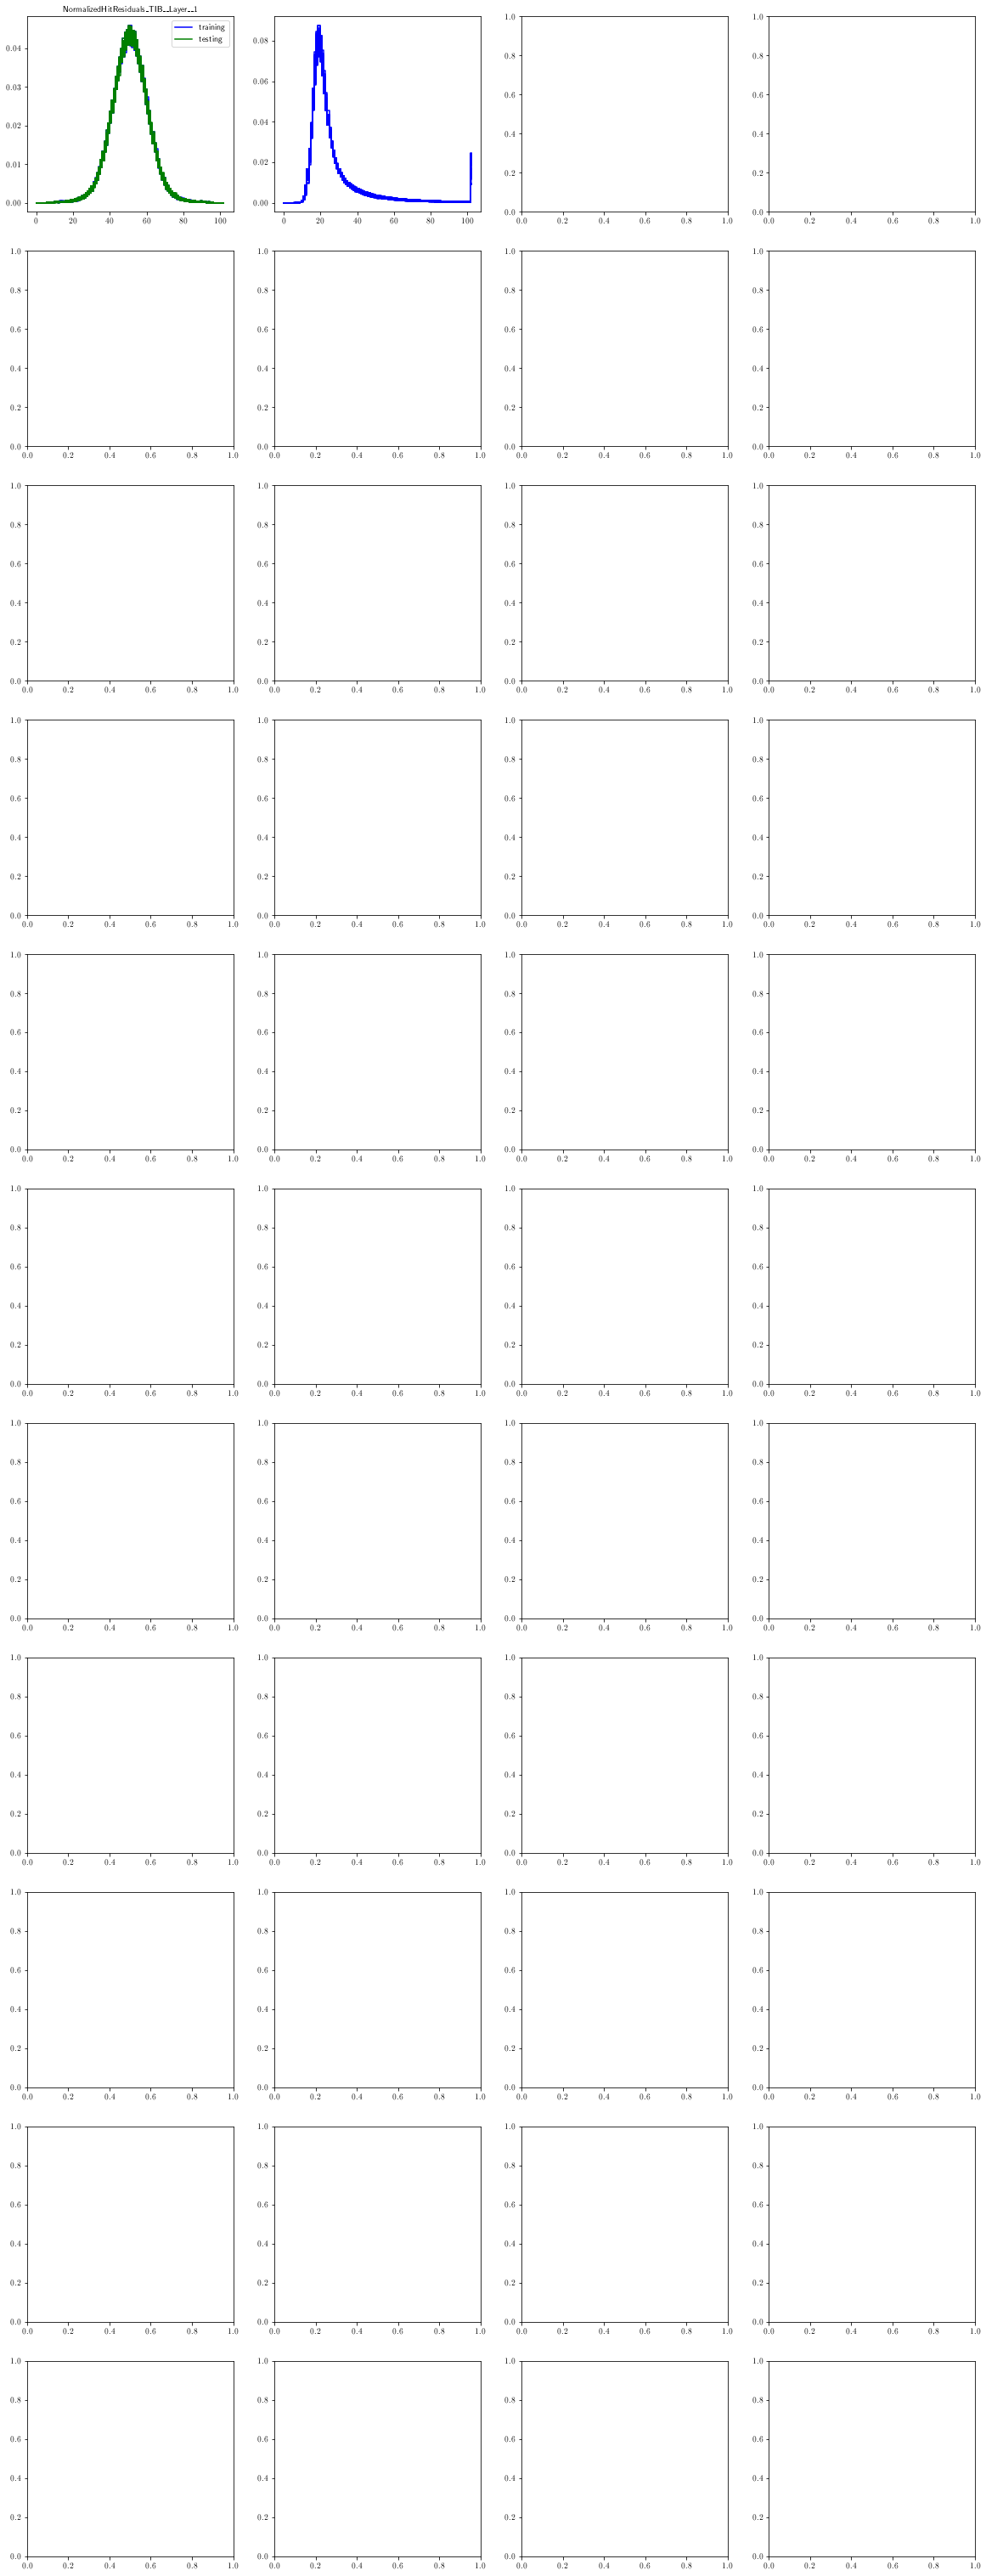

In [50]:
### Plotting the input data for analysis

if((training_mode=='local' or training_mode == 'development') and createPlots):

    # training and application runs
    histstruct.plot_histograms( masknames=[['dcson','highstat','training'],['dcson','highstat','good']],
                                labellist = ['training','testing'],
                                colorlist = ['blue','green']
                              )
    
    # application run and bad test runs
    histstruct.plot_histograms( masknames=[['dcson','highstat','good'],['dcson','highstat','bad']],
                                labellist = ['good','bad'],
                                colorlist = ['green','red']
                              )
    
elif( training_mode=='global' and createPlots):
    
    # bad test runs
    for i in [0,1,2,3,4,5,6]:
        histstruct.plot_histograms( masknames=[['dcson','highstat','good'],['dcson','highstat','bad{}'.format(i)]],
                                labellist = ['typical good histograms','bad'],
                                colorlist = ['blue','red'],
                                transparencylist = [0.01,1.]
                                    )

In [52]:
def define_concatamash_autoencoder(histstruct):
    
    histslist = []
    vallist = []
    autoencoders = []
    if trainnew:
        for i,histnamegroup in enumerate(histnames):
            
            train_normhist = np.array([hu.normalize(histstruct.get_histograms(
                histname = hname, masknames = ['dcson','highstat', 'training']), 
                                                 norm="l1", axis=1) 
                                       for hname in histnamegroup]).transpose((1,0,2))
            X_train, X_val = train_test_split(train_normhist, test_size=0.4, random_state=42)
            
            if userfriendly:
                print('\nNow Defining model {}/'.format(i + 1) 
                      + str(len(histnames)))
                print(' - Size of training set: {}'.format(X_train.shape))
            
            # Half the total bin count
            arch = 51 * len(histnamegroup)
            
            ## Model parameters
            print(X_train.shape)
            
            input_dim = X_train.shape[2] #num of predictor variables
            Input_layers=[Input(shape=input_dim) for i in range((X_train.shape[1]))]
            
            # Defining layers
            conc_layer = Concatenate()(Input_layers)
            encoder = Dense(arch * 2, activation="tanh")(conc_layer)
            #encoder = Dense(128, activation='relu')(encoder)
            #
            #encoder = Dense(32, activation='relu')(encoder)
            
            decoder = Dense(arch, activation="relu")(encoder)
            #decoder = Dense(256, activation="tanh")(decoder)
            
            Output_layers=[Dense(input_dim, activation="tanh")(decoder) for i in range(X_train.shape[1])]

            autoencoder = Model(inputs=Input_layers, outputs=Output_layers)
            autoencoder.summary()
            autoencoders.append(autoencoder)
            
            histslist.append(X_train)
            vallist.append(X_val)
     
    # Return the histograms stored 2-Dimensionally and the autoencoders corresponding
    return(histslist, vallist, autoencoders, train_normhist)

In [53]:
(histslist, vallist, autoencoders, train_normhist) = define_concatamash_autoencoder(histstruct)


Now Defining model 1/12
 - Size of training set: (990, 8, 102)
(990, 8, 102)
Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           [(None, 102)]        0                                            
__________________________________________________________________________________________________
input_42 (InputLayer)           [(None, 102)]        0                                            
__________________________________________________________________________________________________
input_43 (InputLayer)           [(None, 102)]        0                                            
__________________________________________________________________________________________________
input_44 (InputLayer)           [(None, 102)]        0                                            
_____________

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_61 (InputLayer)           [(None, 102)]        0                                            
__________________________________________________________________________________________________
input_62 (InputLayer)           [(None, 102)]        0                                            
__________________________________________________________________________________________________
input_63 (InputLayer)           [(None, 102)]        0                                            
__________________________________________________________________________________________________
input_64 (InputLayer)           [(None, 102)]        0                                            
___________________________________________________________________________________________

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_73 (InputLayer)           [(None, 102)]        0                                            
__________________________________________________________________________________________________
input_74 (InputLayer)           [(None, 102)]        0                                            
__________________________________________________________________________________________________
concatenate_21 (Concatenate)    (None, 204)          0           input_73[0][0]                   
                                                                 input_74[0][0]                   
__________________________________________________________________________________________________
dense_114 (Dense)               (None, 204)          41820       concatenate_21[0][0]      

In [54]:
### Trains a combined autoencoder for every merge set
def train_concatamash_autoencoder(histstruct, histslist, vallist, autoencoders):
    
    # Iterate through the training data to train corresponding autoencoders
    for i in range(len(histslist)):
        
        if userfriendly: print('\nNow training model {}/'.format(i + 1) + str(len(histslist)))
        
        # Set variables to temporary values for better transparency
        X_train = histslist[i]
        X_val = vallist[i]
        autoencoder = autoencoders[i]
        
        
        ## Model parameters
        nb_epoch = 500
        batch_size = 50
        
        #checkpoint_filepath = 'checkpoint'
        #model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        #   filepath=checkpoint_filepath,
        #   save_weights_only=False,
        #   verbose=1,
        #   save_best_only=True,
        #   monitor='val_loss',
        #   mode='min')
        
        # Tell the model when to stop
        earlystop = EarlyStopping(monitor='val_loss',
            min_delta=1e-7,
            patience=20,
            verbose=1,
            mode='auto',
            baseline=None,
            restore_best_weights=True,
        )
        lr =0.001
        opt = keras.optimizers.Adam(learning_rate=lr)
        
        autoencoder.compile(loss='mse',
                            optimizer=opt)
        
        ## Train autoencoder
        train = autoencoder.fit(x=[X_train[:,i] for i in range(X_train.shape[1])],
                                y=[X_train[:,i] for i in range(X_train.shape[1])],
                            epochs=nb_epoch,
                            batch_size=batch_size,
                            shuffle=True,
                            validation_data=([X_val[:,i] for i in range(X_val.shape[1])], [X_val[:,i] for i in range(X_val.shape[1])]),
                            verbose=1,
                            callbacks= [earlystop],    
                            )
        
        # Create a plot of the model
        
        tf.keras.utils.plot_model(
            autoencoder,
            to_file="models/modelConcatamash{}.png".format(i),
            show_shapes=True,
            show_dtype=False,
            show_layer_names=False,
            rankdir="TB")
        
        # Save classifier for evaluation
        classifier = AutoEncoder.AutoEncoder(model=autoencoder)
        histstruct.add_classifier(histnames[i][0], classifier)        

In [55]:
start = time.perf_counter()
train_concatamash_autoencoder(histstruct, histslist, vallist, autoencoders)
stop = time.perf_counter()
print(stop - start)


Now training model 1/12
Epoch 1/500
20/20 [==============================] - 2s 38ms/step - loss: 0.0013 - dense_66_loss: 1.2371e-04 - dense_67_loss: 1.7670e-04 - dense_68_loss: 1.4109e-04 - dense_69_loss: 1.7935e-04 - dense_70_loss: 1.6264e-04 - dense_71_loss: 1.8325e-04 - dense_72_loss: 1.6352e-04 - dense_73_loss: 1.9466e-04 - val_loss: 1.3648e-04 - val_dense_66_loss: 1.3644e-05 - val_dense_67_loss: 2.1692e-05 - val_dense_68_loss: 1.6783e-05 - val_dense_69_loss: 1.5891e-05 - val_dense_70_loss: 1.5169e-05 - val_dense_71_loss: 1.7129e-05 - val_dense_72_loss: 1.7013e-05 - val_dense_73_loss: 1.9162e-05
Epoch 2/500
20/20 [==============================] - 0s 12ms/step - loss: 6.6833e-05 - dense_66_loss: 8.0176e-06 - dense_67_loss: 9.4118e-06 - dense_68_loss: 8.2731e-06 - dense_69_loss: 7.2902e-06 - dense_70_loss: 7.7419e-06 - dense_71_loss: 7.2116e-06 - dense_72_loss: 8.9295e-06 - dense_73_loss: 9.9576e-06 - val_loss: 1.9003e-05 - val_dense_66_loss: 2.6031e-06 - val_dense_67_loss: 2.7247

Epoch 15/500
20/20 [==============================] - 0s 15ms/step - loss: 3.4556e-06 - dense_66_loss: 3.0892e-07 - dense_67_loss: 6.6365e-07 - dense_68_loss: 2.9654e-07 - dense_69_loss: 4.8262e-07 - dense_70_loss: 4.2073e-07 - dense_71_loss: 4.1184e-07 - dense_72_loss: 4.4621e-07 - dense_73_loss: 4.2509e-07 - val_loss: 4.6485e-06 - val_dense_66_loss: 5.3450e-07 - val_dense_67_loss: 7.3483e-07 - val_dense_68_loss: 4.7985e-07 - val_dense_69_loss: 6.2304e-07 - val_dense_70_loss: 5.9636e-07 - val_dense_71_loss: 4.7415e-07 - val_dense_72_loss: 5.9110e-07 - val_dense_73_loss: 6.1464e-07
Epoch 16/500
20/20 [==============================] - 0s 13ms/step - loss: 4.1644e-06 - dense_66_loss: 3.8760e-07 - dense_67_loss: 7.4425e-07 - dense_68_loss: 4.0210e-07 - dense_69_loss: 5.7092e-07 - dense_70_loss: 5.0267e-07 - dense_71_loss: 4.9511e-07 - dense_72_loss: 5.3572e-07 - dense_73_loss: 5.2608e-07 - val_loss: 2.5874e-06 - val_dense_66_loss: 1.9411e-07 - val_dense_67_loss: 5.4079e-07 - val_dense_68

Epoch 29/500
20/20 [==============================] - 0s 12ms/step - loss: 4.0589e-06 - dense_66_loss: 3.6860e-07 - dense_67_loss: 7.2537e-07 - dense_68_loss: 3.8521e-07 - dense_69_loss: 5.3672e-07 - dense_70_loss: 5.2206e-07 - dense_71_loss: 4.9392e-07 - dense_72_loss: 5.3150e-07 - dense_73_loss: 4.9556e-07 - val_loss: 3.8188e-06 - val_dense_66_loss: 3.7171e-07 - val_dense_67_loss: 6.6003e-07 - val_dense_68_loss: 3.4641e-07 - val_dense_69_loss: 5.4370e-07 - val_dense_70_loss: 4.2017e-07 - val_dense_71_loss: 4.4076e-07 - val_dense_72_loss: 5.6665e-07 - val_dense_73_loss: 4.6937e-07
Epoch 30/500
20/20 [==============================] - 0s 12ms/step - loss: 3.8202e-06 - dense_66_loss: 3.4555e-07 - dense_67_loss: 6.9798e-07 - dense_68_loss: 3.6079e-07 - dense_69_loss: 5.2669e-07 - dense_70_loss: 4.4632e-07 - dense_71_loss: 4.4908e-07 - dense_72_loss: 5.2083e-07 - dense_73_loss: 4.7294e-07 - val_loss: 3.7311e-06 - val_dense_66_loss: 3.7547e-07 - val_dense_67_loss: 6.3360e-07 - val_dense_68

Epoch 11/500
20/20 [==============================] - 0s 7ms/step - loss: 1.2820e-05 - dense_76_loss: 5.0481e-06 - dense_77_loss: 1.2173e-06 - dense_78_loss: 2.0426e-06 - dense_79_loss: 4.5124e-06 - val_loss: 1.0809e-05 - val_dense_76_loss: 4.6491e-06 - val_dense_77_loss: 1.0106e-06 - val_dense_78_loss: 1.4881e-06 - val_dense_79_loss: 3.6610e-06
Epoch 12/500
20/20 [==============================] - 0s 5ms/step - loss: 1.1075e-05 - dense_76_loss: 4.5690e-06 - dense_77_loss: 1.0339e-06 - dense_78_loss: 1.3730e-06 - dense_79_loss: 4.0995e-06 - val_loss: 9.4788e-06 - val_dense_76_loss: 4.1107e-06 - val_dense_77_loss: 9.0565e-07 - val_dense_78_loss: 1.1310e-06 - val_dense_79_loss: 3.3313e-06
Epoch 13/500
20/20 [==============================] - 0s 5ms/step - loss: 1.0078e-05 - dense_76_loss: 4.1444e-06 - dense_77_loss: 9.8505e-07 - dense_78_loss: 1.1487e-06 - dense_79_loss: 3.7994e-06 - val_loss: 8.5633e-06 - val_dense_76_loss: 3.6591e-06 - val_dense_77_loss: 8.5289e-07 - val_dense_78_loss:

20/20 [==============================] - 0s 5ms/step - loss: 1.3576e-06 - dense_76_loss: 4.1005e-07 - dense_77_loss: 4.6687e-07 - dense_78_loss: 2.2950e-07 - dense_79_loss: 2.5114e-07 - val_loss: 1.4385e-06 - val_dense_76_loss: 4.4799e-07 - val_dense_77_loss: 4.7650e-07 - val_dense_78_loss: 2.4718e-07 - val_dense_79_loss: 2.6686e-07
Epoch 35/500
20/20 [==============================] - 0s 5ms/step - loss: 1.6467e-06 - dense_76_loss: 4.7147e-07 - dense_77_loss: 5.5114e-07 - dense_78_loss: 2.9770e-07 - dense_79_loss: 3.2640e-07 - val_loss: 1.3529e-06 - val_dense_76_loss: 3.9315e-07 - val_dense_77_loss: 4.6520e-07 - val_dense_78_loss: 2.4835e-07 - val_dense_79_loss: 2.4617e-07
Epoch 36/500
20/20 [==============================] - 0s 5ms/step - loss: 1.3738e-06 - dense_76_loss: 3.7652e-07 - dense_77_loss: 4.8333e-07 - dense_78_loss: 2.4507e-07 - dense_79_loss: 2.6885e-07 - val_loss: 1.3471e-06 - val_dense_76_loss: 3.8245e-07 - val_dense_77_loss: 4.3646e-07 - val_dense_78_loss: 2.6118e-07 -

Epoch 58/500
20/20 [==============================] - 0s 5ms/step - loss: 1.0349e-06 - dense_76_loss: 2.1256e-07 - dense_77_loss: 3.9779e-07 - dense_78_loss: 1.9172e-07 - dense_79_loss: 2.3287e-07 - val_loss: 1.4249e-06 - val_dense_76_loss: 3.6344e-07 - val_dense_77_loss: 4.6792e-07 - val_dense_78_loss: 2.9157e-07 - val_dense_79_loss: 3.0198e-07
Epoch 59/500
20/20 [==============================] - 0s 5ms/step - loss: 1.4213e-06 - dense_76_loss: 3.3596e-07 - dense_77_loss: 4.9171e-07 - dense_78_loss: 2.6789e-07 - dense_79_loss: 3.2573e-07 - val_loss: 1.4755e-06 - val_dense_76_loss: 3.3389e-07 - val_dense_77_loss: 5.1164e-07 - val_dense_78_loss: 3.1034e-07 - val_dense_79_loss: 3.1963e-07
Epoch 60/500
20/20 [==============================] - 0s 5ms/step - loss: 1.1032e-06 - dense_76_loss: 2.3252e-07 - dense_77_loss: 4.2106e-07 - dense_78_loss: 2.1285e-07 - dense_79_loss: 2.3675e-07 - val_loss: 7.8010e-07 - val_dense_76_loss: 1.5662e-07 - val_dense_77_loss: 3.2881e-07 - val_dense_78_loss:

20/20 [==============================] - 0s 5ms/step - loss: 2.0519e-06 - dense_82_loss: 7.4752e-07 - dense_83_loss: 7.1454e-07 - dense_84_loss: 2.9171e-07 - dense_85_loss: 2.9808e-07 - val_loss: 1.7872e-06 - val_dense_82_loss: 6.3816e-07 - val_dense_83_loss: 6.1189e-07 - val_dense_84_loss: 2.6748e-07 - val_dense_85_loss: 2.6962e-07
Epoch 19/500
20/20 [==============================] - 0s 5ms/step - loss: 2.0514e-06 - dense_82_loss: 7.4198e-07 - dense_83_loss: 7.0887e-07 - dense_84_loss: 2.9620e-07 - dense_85_loss: 3.0437e-07 - val_loss: 1.7997e-06 - val_dense_82_loss: 6.4120e-07 - val_dense_83_loss: 6.0748e-07 - val_dense_84_loss: 2.7530e-07 - val_dense_85_loss: 2.7577e-07
Epoch 20/500
20/20 [==============================] - 0s 5ms/step - loss: 2.0368e-06 - dense_82_loss: 7.3541e-07 - dense_83_loss: 7.0304e-07 - dense_84_loss: 2.9293e-07 - dense_85_loss: 3.0538e-07 - val_loss: 1.7762e-06 - val_dense_82_loss: 6.4542e-07 - val_dense_83_loss: 6.1236e-07 - val_dense_84_loss: 2.5455e-07 -

Epoch 42/500
20/20 [==============================] - 0s 6ms/step - loss: 1.8955e-06 - dense_82_loss: 5.5688e-07 - dense_83_loss: 5.7906e-07 - dense_84_loss: 3.6007e-07 - dense_85_loss: 3.9953e-07 - val_loss: 1.6432e-06 - val_dense_82_loss: 4.9904e-07 - val_dense_83_loss: 4.9627e-07 - val_dense_84_loss: 3.1047e-07 - val_dense_85_loss: 3.3741e-07
Epoch 43/500
20/20 [==============================] - 0s 4ms/step - loss: 1.8746e-06 - dense_82_loss: 5.5129e-07 - dense_83_loss: 5.6558e-07 - dense_84_loss: 3.6613e-07 - dense_85_loss: 3.9156e-07 - val_loss: 1.6917e-06 - val_dense_82_loss: 4.7872e-07 - val_dense_83_loss: 5.2288e-07 - val_dense_84_loss: 3.2101e-07 - val_dense_85_loss: 3.6912e-07
Epoch 44/500
20/20 [==============================] - 0s 5ms/step - loss: 1.8452e-06 - dense_82_loss: 5.2990e-07 - dense_83_loss: 5.4978e-07 - dense_84_loss: 3.5955e-07 - dense_85_loss: 4.0594e-07 - val_loss: 1.7870e-06 - val_dense_82_loss: 4.8258e-07 - val_dense_83_loss: 5.2753e-07 - val_dense_84_loss:

20/20 [==============================] - 0s 7ms/step - loss: 1.1353e-06 - dense_82_loss: 2.8235e-07 - dense_83_loss: 2.9639e-07 - dense_84_loss: 2.5761e-07 - dense_85_loss: 2.9896e-07 - val_loss: 1.0078e-06 - val_dense_82_loss: 2.5530e-07 - val_dense_83_loss: 2.6774e-07 - val_dense_84_loss: 2.3304e-07 - val_dense_85_loss: 2.5176e-07
Epoch 66/500
20/20 [==============================] - 0s 5ms/step - loss: 1.2000e-06 - dense_82_loss: 3.0091e-07 - dense_83_loss: 3.1111e-07 - dense_84_loss: 2.7526e-07 - dense_85_loss: 3.1268e-07 - val_loss: 1.1052e-06 - val_dense_82_loss: 2.6165e-07 - val_dense_83_loss: 2.8980e-07 - val_dense_84_loss: 2.3697e-07 - val_dense_85_loss: 3.1677e-07
Epoch 67/500
20/20 [==============================] - 0s 5ms/step - loss: 1.1672e-06 - dense_82_loss: 2.9390e-07 - dense_83_loss: 3.0856e-07 - dense_84_loss: 2.5798e-07 - dense_85_loss: 3.0671e-07 - val_loss: 1.0419e-06 - val_dense_82_loss: 2.8368e-07 - val_dense_83_loss: 2.6558e-07 - val_dense_84_loss: 2.3967e-07 -

20/20 [==============================] - 0s 5ms/step - loss: 2.5274e-05 - dense_88_loss: 6.0945e-06 - dense_89_loss: 5.2236e-06 - dense_90_loss: 1.0374e-05 - dense_91_loss: 3.5816e-06 - val_loss: 1.6143e-05 - val_dense_88_loss: 3.3688e-06 - val_dense_89_loss: 3.1894e-06 - val_dense_90_loss: 7.8259e-06 - val_dense_91_loss: 1.7593e-06
Epoch 4/500
20/20 [==============================] - 0s 6ms/step - loss: 1.3854e-05 - dense_88_loss: 2.9435e-06 - dense_89_loss: 2.8352e-06 - dense_90_loss: 7.0559e-06 - dense_91_loss: 1.0192e-06 - val_loss: 1.2842e-05 - val_dense_88_loss: 2.6045e-06 - val_dense_89_loss: 2.6136e-06 - val_dense_90_loss: 6.8125e-06 - val_dense_91_loss: 8.1132e-07
Epoch 5/500
20/20 [==============================] - 0s 6ms/step - loss: 1.2203e-05 - dense_88_loss: 2.5408e-06 - dense_89_loss: 2.5185e-06 - dense_90_loss: 6.4519e-06 - dense_91_loss: 6.9207e-07 - val_loss: 1.2201e-05 - val_dense_88_loss: 2.4889e-06 - val_dense_89_loss: 2.4830e-06 - val_dense_90_loss: 6.5691e-06 - v

Epoch 27/500
20/20 [==============================] - 0s 5ms/step - loss: 8.8858e-07 - dense_88_loss: 2.5744e-07 - dense_89_loss: 2.4831e-07 - dense_90_loss: 2.0649e-07 - dense_91_loss: 1.7635e-07 - val_loss: 9.4096e-07 - val_dense_88_loss: 2.6688e-07 - val_dense_89_loss: 2.7686e-07 - val_dense_90_loss: 1.9623e-07 - val_dense_91_loss: 2.0098e-07
Epoch 28/500
20/20 [==============================] - 0s 6ms/step - loss: 9.8168e-07 - dense_88_loss: 2.7543e-07 - dense_89_loss: 2.7474e-07 - dense_90_loss: 2.3003e-07 - dense_91_loss: 2.0148e-07 - val_loss: 7.9035e-07 - val_dense_88_loss: 2.3280e-07 - val_dense_89_loss: 2.2141e-07 - val_dense_90_loss: 1.7647e-07 - val_dense_91_loss: 1.5966e-07
Epoch 29/500
20/20 [==============================] - 0s 5ms/step - loss: 8.7483e-07 - dense_88_loss: 2.5780e-07 - dense_89_loss: 2.4484e-07 - dense_90_loss: 2.0118e-07 - dense_91_loss: 1.7101e-07 - val_loss: 9.4535e-07 - val_dense_88_loss: 2.6735e-07 - val_dense_89_loss: 2.5781e-07 - val_dense_90_loss:

20/20 [==============================] - 0s 6ms/step - loss: 1.5407e-05 - dense_94_loss: 2.1975e-06 - dense_95_loss: 1.8761e-06 - dense_96_loss: 1.0255e-05 - dense_97_loss: 1.0784e-06 - val_loss: 1.5269e-05 - val_dense_94_loss: 2.2186e-06 - val_dense_95_loss: 1.8974e-06 - val_dense_96_loss: 1.0030e-05 - val_dense_97_loss: 1.1228e-06
Epoch 9/500
20/20 [==============================] - 0s 6ms/step - loss: 1.4507e-05 - dense_94_loss: 2.1505e-06 - dense_95_loss: 1.8235e-06 - dense_96_loss: 9.3839e-06 - dense_97_loss: 1.1496e-06 - val_loss: 1.4232e-05 - val_dense_94_loss: 2.1692e-06 - val_dense_95_loss: 1.8325e-06 - val_dense_96_loss: 9.0295e-06 - val_dense_97_loss: 1.2005e-06
Epoch 10/500
20/20 [==============================] - 0s 4ms/step - loss: 1.3371e-05 - dense_94_loss: 2.0877e-06 - dense_95_loss: 1.7525e-06 - dense_96_loss: 8.3062e-06 - dense_97_loss: 1.2246e-06 - val_loss: 1.2839e-05 - val_dense_94_loss: 2.0490e-06 - val_dense_95_loss: 1.7353e-06 - val_dense_96_loss: 7.7963e-06 - 

Epoch 32/500
20/20 [==============================] - 0s 6ms/step - loss: 8.7866e-07 - dense_94_loss: 2.5756e-07 - dense_95_loss: 2.7691e-07 - dense_96_loss: 1.6924e-07 - dense_97_loss: 1.7495e-07 - val_loss: 9.9578e-07 - val_dense_94_loss: 3.0379e-07 - val_dense_95_loss: 3.0459e-07 - val_dense_96_loss: 1.8419e-07 - val_dense_97_loss: 2.0321e-07
Epoch 33/500
20/20 [==============================] - 0s 5ms/step - loss: 1.0314e-06 - dense_94_loss: 2.9188e-07 - dense_95_loss: 3.2440e-07 - dense_96_loss: 2.0087e-07 - dense_97_loss: 2.1426e-07 - val_loss: 1.2347e-06 - val_dense_94_loss: 3.4282e-07 - val_dense_95_loss: 3.6266e-07 - val_dense_96_loss: 2.7811e-07 - val_dense_97_loss: 2.5111e-07
Epoch 34/500
20/20 [==============================] - 0s 6ms/step - loss: 9.7746e-07 - dense_94_loss: 2.8143e-07 - dense_95_loss: 3.0245e-07 - dense_96_loss: 1.9362e-07 - dense_97_loss: 1.9996e-07 - val_loss: 9.8028e-07 - val_dense_94_loss: 2.8725e-07 - val_dense_95_loss: 2.9876e-07 - val_dense_96_loss:

Epoch 24/500
20/20 [==============================] - 0s 3ms/step - loss: 1.0846e-06 - dense_100_loss: 8.0105e-07 - dense_101_loss: 2.8352e-07 - val_loss: 8.9452e-07 - val_dense_100_loss: 6.3505e-07 - val_dense_101_loss: 2.5947e-07
Epoch 25/500
20/20 [==============================] - 0s 3ms/step - loss: 1.0762e-06 - dense_100_loss: 7.9070e-07 - dense_101_loss: 2.8547e-07 - val_loss: 8.8292e-07 - val_dense_100_loss: 6.2622e-07 - val_dense_101_loss: 2.5671e-07
Epoch 26/500
20/20 [==============================] - 0s 3ms/step - loss: 1.0791e-06 - dense_100_loss: 7.8835e-07 - dense_101_loss: 2.9070e-07 - val_loss: 8.8316e-07 - val_dense_100_loss: 6.2171e-07 - val_dense_101_loss: 2.6144e-07
Epoch 27/500
20/20 [==============================] - 0s 3ms/step - loss: 1.0537e-06 - dense_100_loss: 7.6840e-07 - dense_101_loss: 2.8534e-07 - val_loss: 8.7607e-07 - val_dense_100_loss: 6.1821e-07 - val_dense_101_loss: 2.5786e-07
Epoch 28/500
20/20 [==============================] - 0s 3ms/step - loss

20/20 [==============================] - 0s 3ms/step - loss: 4.7064e-07 - dense_100_loss: 2.5288e-07 - dense_101_loss: 2.1776e-07 - val_loss: 4.6299e-07 - val_dense_100_loss: 2.4639e-07 - val_dense_101_loss: 2.1661e-07
Epoch 60/500
20/20 [==============================] - 0s 3ms/step - loss: 4.6470e-07 - dense_100_loss: 2.4916e-07 - dense_101_loss: 2.1554e-07 - val_loss: 4.2268e-07 - val_dense_100_loss: 2.1982e-07 - val_dense_101_loss: 2.0286e-07
Epoch 61/500
20/20 [==============================] - 0s 3ms/step - loss: 4.4507e-07 - dense_100_loss: 2.3448e-07 - dense_101_loss: 2.1060e-07 - val_loss: 4.1516e-07 - val_dense_100_loss: 2.1599e-07 - val_dense_101_loss: 1.9917e-07
Epoch 62/500
20/20 [==============================] - 0s 3ms/step - loss: 4.3726e-07 - dense_100_loss: 2.2809e-07 - dense_101_loss: 2.0916e-07 - val_loss: 4.5583e-07 - val_dense_100_loss: 2.2830e-07 - val_dense_101_loss: 2.2753e-07
Epoch 63/500
20/20 [==============================] - 0s 3ms/step - loss: 4.3005e-07 

Epoch 9/500
20/20 [==============================] - 0s 3ms/step - loss: 1.3517e-06 - dense_104_loss: 1.0505e-06 - dense_105_loss: 3.0117e-07 - val_loss: 1.0725e-06 - val_dense_104_loss: 8.0065e-07 - val_dense_105_loss: 2.7181e-07
Epoch 10/500
20/20 [==============================] - 0s 3ms/step - loss: 1.3024e-06 - dense_104_loss: 1.0116e-06 - dense_105_loss: 2.9079e-07 - val_loss: 1.0340e-06 - val_dense_104_loss: 7.7218e-07 - val_dense_105_loss: 2.6185e-07
Epoch 11/500
20/20 [==============================] - 0s 3ms/step - loss: 1.2763e-06 - dense_104_loss: 9.8555e-07 - dense_105_loss: 2.9079e-07 - val_loss: 1.0367e-06 - val_dense_104_loss: 7.6478e-07 - val_dense_105_loss: 2.7187e-07
Epoch 12/500
20/20 [==============================] - 0s 3ms/step - loss: 1.2421e-06 - dense_104_loss: 9.5547e-07 - dense_105_loss: 2.8662e-07 - val_loss: 9.9824e-07 - val_dense_104_loss: 7.3691e-07 - val_dense_105_loss: 2.6133e-07
Epoch 13/500
20/20 [==============================] - 0s 3ms/step - loss:

20/20 [==============================] - 0s 4ms/step - loss: 3.7808e-07 - dense_104_loss: 1.8068e-07 - dense_105_loss: 1.9740e-07 - val_loss: 4.0615e-07 - val_dense_104_loss: 1.8675e-07 - val_dense_105_loss: 2.1940e-07
Epoch 45/500
20/20 [==============================] - 0s 3ms/step - loss: 3.6679e-07 - dense_104_loss: 1.7382e-07 - dense_105_loss: 1.9297e-07 - val_loss: 3.3279e-07 - val_dense_104_loss: 1.5603e-07 - val_dense_105_loss: 1.7676e-07
Epoch 46/500
20/20 [==============================] - 0s 3ms/step - loss: 3.4168e-07 - dense_104_loss: 1.6142e-07 - dense_105_loss: 1.8026e-07 - val_loss: 3.2790e-07 - val_dense_104_loss: 1.5141e-07 - val_dense_105_loss: 1.7649e-07
Epoch 47/500
20/20 [==============================] - 0s 3ms/step - loss: 3.4148e-07 - dense_104_loss: 1.6028e-07 - dense_105_loss: 1.8120e-07 - val_loss: 3.6964e-07 - val_dense_104_loss: 1.8359e-07 - val_dense_105_loss: 1.8605e-07
Epoch 48/500
20/20 [==============================] - 0s 3ms/step - loss: 3.3092e-07 

Epoch 11/500
20/20 [==============================] - 0s 3ms/step - loss: 1.1523e-06 - dense_108_loss: 8.7316e-07 - dense_109_loss: 2.7917e-07 - val_loss: 9.6837e-07 - val_dense_108_loss: 7.0380e-07 - val_dense_109_loss: 2.6458e-07
Epoch 12/500
20/20 [==============================] - 0s 3ms/step - loss: 1.1459e-06 - dense_108_loss: 8.6715e-07 - dense_109_loss: 2.7870e-07 - val_loss: 9.5247e-07 - val_dense_108_loss: 6.8953e-07 - val_dense_109_loss: 2.6294e-07
Epoch 13/500
20/20 [==============================] - 0s 3ms/step - loss: 1.1318e-06 - dense_108_loss: 8.5568e-07 - dense_109_loss: 2.7614e-07 - val_loss: 9.4658e-07 - val_dense_108_loss: 6.8498e-07 - val_dense_109_loss: 2.6160e-07
Epoch 14/500
20/20 [==============================] - 0s 4ms/step - loss: 1.1304e-06 - dense_108_loss: 8.5475e-07 - dense_109_loss: 2.7568e-07 - val_loss: 9.3742e-07 - val_dense_108_loss: 6.8121e-07 - val_dense_109_loss: 2.5621e-07
Epoch 15/500
20/20 [==============================] - 0s 3ms/step - loss

Epoch 6/500
20/20 [==============================] - 0s 4ms/step - loss: 1.2421e-06 - dense_112_loss: 9.0547e-07 - dense_113_loss: 3.3663e-07 - val_loss: 9.8778e-07 - val_dense_112_loss: 6.9302e-07 - val_dense_113_loss: 2.9475e-07
Epoch 7/500
20/20 [==============================] - 0s 4ms/step - loss: 1.1773e-06 - dense_112_loss: 8.6429e-07 - dense_113_loss: 3.1302e-07 - val_loss: 9.4326e-07 - val_dense_112_loss: 6.6461e-07 - val_dense_113_loss: 2.7865e-07
Epoch 8/500
20/20 [==============================] - 0s 3ms/step - loss: 1.1401e-06 - dense_112_loss: 8.3805e-07 - dense_113_loss: 3.0209e-07 - val_loss: 9.1505e-07 - val_dense_112_loss: 6.4442e-07 - val_dense_113_loss: 2.7062e-07
Epoch 9/500
20/20 [==============================] - 0s 3ms/step - loss: 1.1146e-06 - dense_112_loss: 8.1780e-07 - dense_113_loss: 2.9684e-07 - val_loss: 9.0371e-07 - val_dense_112_loss: 6.3473e-07 - val_dense_113_loss: 2.6898e-07
Epoch 10/500
20/20 [==============================] - 0s 3ms/step - loss: 1.

Epoch 8/500
20/20 [==============================] - 0s 3ms/step - loss: 1.0717e-06 - dense_116_loss: 7.4706e-07 - dense_117_loss: 3.2465e-07 - val_loss: 9.0493e-07 - val_dense_116_loss: 5.9975e-07 - val_dense_117_loss: 3.0518e-07
Epoch 9/500
20/20 [==============================] - 0s 3ms/step - loss: 1.0524e-06 - dense_116_loss: 7.3746e-07 - dense_117_loss: 3.1492e-07 - val_loss: 8.8069e-07 - val_dense_116_loss: 5.9150e-07 - val_dense_117_loss: 2.8919e-07
Epoch 10/500
20/20 [==============================] - 0s 3ms/step - loss: 1.0189e-06 - dense_116_loss: 7.1907e-07 - dense_117_loss: 2.9980e-07 - val_loss: 8.5276e-07 - val_dense_116_loss: 5.7044e-07 - val_dense_117_loss: 2.8232e-07
Epoch 11/500
20/20 [==============================] - 0s 3ms/step - loss: 1.0021e-06 - dense_116_loss: 7.0887e-07 - dense_117_loss: 2.9321e-07 - val_loss: 8.4891e-07 - val_dense_116_loss: 5.6904e-07 - val_dense_117_loss: 2.7988e-07
Epoch 12/500
20/20 [==============================] - 0s 3ms/step - loss: 

Epoch 10/500
20/20 [==============================] - 0s 3ms/step - loss: 9.5973e-07 - dense_120_loss: 6.8281e-07 - dense_121_loss: 2.7692e-07 - val_loss: 8.0066e-07 - val_dense_120_loss: 5.4697e-07 - val_dense_121_loss: 2.5369e-07
Epoch 11/500
20/20 [==============================] - 0s 3ms/step - loss: 9.5192e-07 - dense_120_loss: 6.7826e-07 - dense_121_loss: 2.7366e-07 - val_loss: 8.0351e-07 - val_dense_120_loss: 5.4872e-07 - val_dense_121_loss: 2.5479e-07
Epoch 12/500
20/20 [==============================] - 0s 3ms/step - loss: 9.4682e-07 - dense_120_loss: 6.7443e-07 - dense_121_loss: 2.7239e-07 - val_loss: 7.9030e-07 - val_dense_120_loss: 5.3997e-07 - val_dense_121_loss: 2.5033e-07
Epoch 13/500
20/20 [==============================] - 0s 3ms/step - loss: 9.3505e-07 - dense_120_loss: 6.6912e-07 - dense_121_loss: 2.6593e-07 - val_loss: 7.8625e-07 - val_dense_120_loss: 5.4199e-07 - val_dense_121_loss: 2.4426e-07
Epoch 14/500
20/20 [==============================] - 0s 3ms/step - loss

Epoch 8/500
20/20 [==============================] - 0s 13ms/step - loss: 5.9613e-06 - dense_124_loss: 5.9751e-07 - dense_125_loss: 9.7832e-07 - dense_126_loss: 5.6873e-07 - dense_127_loss: 8.1772e-07 - dense_128_loss: 6.7338e-07 - dense_129_loss: 8.1094e-07 - dense_130_loss: 7.5207e-07 - dense_131_loss: 7.6263e-07 - val_loss: 4.1594e-06 - val_dense_124_loss: 4.1379e-07 - val_dense_125_loss: 7.3645e-07 - val_dense_126_loss: 3.8330e-07 - val_dense_127_loss: 5.7277e-07 - val_dense_128_loss: 4.7733e-07 - val_dense_129_loss: 5.1009e-07 - val_dense_130_loss: 5.4922e-07 - val_dense_131_loss: 5.1644e-07
Epoch 9/500
20/20 [==============================] - 0s 18ms/step - loss: 4.9052e-06 - dense_124_loss: 4.4602e-07 - dense_125_loss: 8.4043e-07 - dense_126_loss: 4.4412e-07 - dense_127_loss: 6.8278e-07 - dense_128_loss: 5.9188e-07 - dense_129_loss: 6.3140e-07 - dense_130_loss: 6.3571e-07 - dense_131_loss: 6.3288e-07 - val_loss: 4.5035e-06 - val_dense_124_loss: 4.0224e-07 - val_dense_125_loss: 7

Epoch 22/500
20/20 [==============================] - 0s 13ms/step - loss: 4.1051e-06 - dense_124_loss: 3.7566e-07 - dense_125_loss: 6.7396e-07 - dense_126_loss: 3.7322e-07 - dense_127_loss: 5.4967e-07 - dense_128_loss: 5.1231e-07 - dense_129_loss: 5.4256e-07 - dense_130_loss: 5.4087e-07 - dense_131_loss: 5.3683e-07 - val_loss: 3.6936e-06 - val_dense_124_loss: 3.0474e-07 - val_dense_125_loss: 6.3608e-07 - val_dense_126_loss: 2.9554e-07 - val_dense_127_loss: 4.9471e-07 - val_dense_128_loss: 4.8225e-07 - val_dense_129_loss: 4.9054e-07 - val_dense_130_loss: 4.9876e-07 - val_dense_131_loss: 4.9098e-07
Epoch 23/500
20/20 [==============================] - 0s 13ms/step - loss: 3.8760e-06 - dense_124_loss: 3.3960e-07 - dense_125_loss: 6.6273e-07 - dense_126_loss: 3.4961e-07 - dense_127_loss: 5.1988e-07 - dense_128_loss: 4.7497e-07 - dense_129_loss: 4.9074e-07 - dense_130_loss: 5.1507e-07 - dense_131_loss: 5.2335e-07 - val_loss: 3.3199e-06 - val_dense_124_loss: 2.8226e-07 - val_dense_125_loss:

In [56]:
### Evaluate the Models for WP definition
def evaluate_models_train(histstruct):
    
    for histgroup in histnames:
        print('evaluating model for '+histgroup[0])
        print(histstruct.evaluate_classifier(histgroup)[0].shape)
    
    # get mse for training set
    if 'training' in histstruct.masks.keys(): masknames = ['dcson','highstat', 'training']
    else: masknames = ['dcson','highstat']
    mse_train = histstruct.get_scores_array( masknames=masknames )
    print('Found mse array for training set of following shape: {}'.format(mse_train.shape))
    
    # get mse for good set
    if 'good' in histstruct.masks.keys():
        mse_good = []
        for histname in histstruct.histnames:
            mse_good.append(histstruct.get_scores( histname=histname, masknames=['dcson','highstat','good'] ))
    else:
        mse_good = []
        for histname in histstruct.histnames:
            hists_good = hu.averagehists( histstruct.get_histograms( histname=histname, masknames=['dcson','highstat']), 1000 )
            thismse = histstruct.classifiers[histname].evaluate( hists_good )
            mse_good.append( thismse )
            print(run)
    mse_good = np.array(mse_good)
    mse_good = np.transpose(mse_good)
    print('Found mse array for good set of following shape: {}'.format(mse_good.shape))
    
    # get mse for bad sets
    mse_bad = []
    for i in range(nbadruns):
        mse_bad.append( histstruct.get_scores_array( masknames=['dcson','highstat','bad{}'.format(i)] ) )
        print('Found mse array for bad set of following shape: {}'.format(mse_bad[i].shape))
        
    return [mse_train, mse_good, mse_bad]

In [57]:
(mse_train, mse_good_eval, mse_bad_eval) = evaluate_models_train(histstruct)

evaluating model for NormalizedHitResiduals_TIB__Layer__1
(2831,)
evaluating model for chargeInner_PXLayer_1
(2831,)
evaluating model for chargeInner_PXLayer_2
(2831,)
evaluating model for chargeInner_PXLayer_3
(2831,)
evaluating model for chargeInner_PXLayer_4
(2831,)
evaluating model for charge_PXDisk_+1
(2831,)
evaluating model for charge_PXDisk_-1
(2831,)
evaluating model for charge_PXDisk_+2
(2831,)
evaluating model for charge_PXDisk_-2
(2831,)
evaluating model for charge_PXDisk_+3
(2831,)
evaluating model for charge_PXDisk_-3
(2831,)
evaluating model for NormalizedHitResiduals_TOB__Layer__1
(2831,)
Found mse array for training set of following shape: (1651, 44)
Found mse array for good set of following shape: (1509, 44)
Found mse array for bad set of following shape: (43, 44)
Found mse array for bad set of following shape: (34, 44)
Found mse array for bad set of following shape: (45, 44)
Found mse array for bad set of following shape: (8, 44)
Found mse array for bad set of follow

In [58]:
### Plots and Distribution Analysis
def fit_mse_distribution(histstruct, mse_train):
    dimslist = []
    fitfunclist = []
    
    
    nhisttypes = len(histstruct.histnames)
    for i in range(0,nhisttypes-1):
        for j in range(i+1,nhisttypes):
            dimslist.append((i, j))
    
    plt.close('all')
    (npoints,ndims) = mse_train.shape
    
    
    # settings for GaussianKdeFitter
    scott_bw = npoints**(-1./(ndims+4))
    bw_method = 20*scott_bw
    # settings for HyperRectangleFitter
    quantiles = ([0.00062,0.0006,0.00015,0.00015,
                 0.0003,0.0003,0.00053,0.00065])
    
    
    #for dims in dimslist:
    #    thismse = mse_train[:,dims]
    #    if training_mode=='global': 
    #        fitfunc = SeminormalFitter.SeminormalFitter(thismse)
    #        #fitfunc = HyperRectangleFitter.HyperRectangleFitter(thismse, 
    #        #                                                    [quantiles[dims[0]],quantiles[dims[1]]],
    #        #                                                    'up')
    #    else: fitfunc = GaussianKdeFitter.GaussianKdeFitter(thismse,bw_method=bw_method)
    #    #pu.plot_fit_2d(thismse, fitfunc=fitfunc, logprob=True, clipprob=True,
    #    #                onlycontour=False, xlims=30, ylims=30, 
    #    #                onlypositive=True, transparency=0.5,
    #    #                xaxtitle=histstruct.histnames[dims[0]], 
    #    #                yaxtitle=histstruct.histnames[dims[1]],
    #    #                title='density fit of lumisection MSE')
    #    ##plt.close('all') # release plot memory
    #    fitfunclist.append(fitfunc)
    # 
    #    
    if training_mode=='global': 
        fitfunc = SeminormalFitter.SeminormalFitter(mse_train)
        #fitfunc = HyperRectangleFitter.HyperRectangleFitter(mse_train, quantiles, 'up')
    else: 
        fitfunc = GaussianKdeFitter.GaussianKdeFitter()
        fitfunc.fit(mse_train,bw_method=bw_method)
    
    return fitfunc

In [59]:
fitfunc = fit_mse_distribution(histstruct, mse_train)

In [60]:
### Prepare MSEs for Working Point Definition
def mse_analysis(histstruct, mse_good_eval, mse_bad_eval, fitfunc):
    
    # Get the minimum log probability of histograms in good set
    print('--- good lumesections ---')
    logprob_good = np.log(fitfunc.pdf(mse_good_eval))
    print('length of log prob array: '+str(len(logprob_good)))
    print('minimum of log prob: '+str(np.min(logprob_good)))
    #print(sorted(logprob_good))
    
    print('--- bad lumisections ---')
    logprob_bad_parts = [np.log(fitfunc.pdf(mse_bad_eval[j])) for j in range(len(mse_bad_eval))]
    #for lp in logprob_bad_parts: print(str(sorted(lp))+'\n\n')
    logprob_bad = np.concatenate(tuple(logprob_bad_parts))
    
    print('length of log prob array: '+str(len(logprob_bad)))
    print('maximum of log prob: '+str(np.max(logprob_bad)))
    #print(sorted(logprob_good))
    #print(sorted(logprob_bad))
    #print(logprob_bad)
    
    return [logprob_good, logprob_bad]

In [61]:
(logprob_good, logprob_bad) = mse_analysis(histstruct, mse_good_eval, mse_bad_eval, fitfunc)

--- good lumesections ---
length of log prob array: 1509
minimum of log prob: 446.4882232220617
--- bad lumisections ---


/tmp/ipykernel_22600/688802665.py:12: RuntimeWarning: divide by zero encountered in log
  logprob_bad_parts = [np.log(fitfunc.pdf(mse_bad_eval[j])) for j in range(len(mse_bad_eval))]


length of log prob array: 223
maximum of log prob: 461.5070628433653


In [62]:
def evaluate_autoencoder_individual(histstruct):
    
    msewps = []
    for histname in histstruct.histnames:
        
        # Get histograms from histstruct
        X_test_good = np.array([hu.normalize(histstruct.get_histograms(
                histname = hname, masknames = ['dcson','highstat', 'good']), 
                                                 norm="l1", axis=1) 
                                       for hname in histnamegroup]).transpose((1,0,2))
        
        X_test_bad = X_test_bad = np.array([hu.normalize(histstruct.get_histograms(
                histname = hname, masknames = ['dcson','highstat', 'bad']), 
                                                 norm="l1", axis=1) 
                                       for hname in histnamegroup]).transpose((1,0,2))
        
        # Get each model from the histstruct
        autoencoder = histstruct.get_classifier(histname)
        
        # Getting evaluation criteria
        prediction_test_good = autoencoder.reconstruct(X_test_good)
        mse_test_good = aeu.mseTopNRaw(X_test_good, prediction_test_good, n=10 )
        prediction_test_bad = autoencoder.reconstruct(X_test_bad)
        mse_test_bad = aeu.mseTopNRaw(X_test_bad, prediction_test_bad, n=10 )
        
        if userfriendly:
            print('Average MSE on good set: ' + str(np.mean(mse_test_good)))
            print('Average MSE on bad set: ' + str(np.mean(mse_test_bad)))
        
        if createPlots:
            # Number of plots of each type to generate per model (so nplot * 2 * len(model))
            nplot = 3
            
            # Good examples
            print('Examples of good histograms and reconstruction:')
            randint = np.random.choice(np.arange(len(X_test_good)),size=nplot,replace=False)
            for i in randint: 
                histlist = [X_test_good[int(i),:],prediction_test_good[int(i),:]]
                labellist = ['data','reconstruction']
                colorlist = ['black','blue']
                pu.plot_hists(histlist,colorlist=colorlist,labellist=labellist)
                plt.show()
            
            # Bad examples
            print('Examples of bad histograms and reconstruction:')
            randint = np.random.choice(np.arange(len(X_test_bad)),size=nplot,replace=False)
            for i in randint:
                histlist = [X_test_bad[int(i),:],prediction_test_bad[int(i),:]]
                labellist = ['data','reconstruction']
                colorlist = ['black','blue']
                pu.plot_hists(histlist,colorlist=colorlist,labellist=labellist)
                plt.show()
        
        # Attaching the bad histograms as a new set of rows under the good histograms
        validation_data = np.vstack((X_test_good, X_test_bad))
        validation_preds = np.vstack((prediction_test_good, prediction_test_bad))
        # Creating labels to differentiate the data when we go to compare predictions
        #     with actual label
        labels = np.hstack((np.zeros(len(X_test_good)), np.ones(len(X_test_bad))))
        
        # Pick a working point to see 
        msewp = 0.5*(np.mean(mse_test_bad) - np.mean(mse_test_good))
        print("Selected working point: " + str(msewp))
        
        # Get data to pick a good working point for future evaluation
        scores = aeu.mseTop10Raw(validation_data, validation_preds)
        nsig = np.sum(labels)
        nback = np.sum(1-labels)
        
        # Get some metrics for the user
        tp = np.sum(np.where((labels==1) & (scores>msewp),1,0))/nsig
        fp = np.sum(np.where((labels==0) & (scores>msewp),1,0))/nback
        tn = 1-fp
        fn = 1-tp
        
        accuracy = (tp + tn) / (tp + fp + tn + fn)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = (2*precision*recall) / (precision + recall)
        
        if userfriendly:
            print(accuracy)
            print(precision)
            print(recall)
            print(f1)
        
    return msewps

In [63]:
def evaluate_autoencoders_combined(logprob_good, logprob_bad, biasFactor):
    labels_good = np.zeros(len(logprob_good)) # background: label = 0
    labels_bad = np.ones(len(logprob_bad)) # signal: label = 1
    
    badMin = min(np.where(logprob_bad != -np.inf, logprob_bad, np.inf))
    goodMax = max(np.where(logprob_good != np.inf, logprob_good, -np.inf))
    
    # Getting rid of infinities
    logprob_good[logprob_good > 500] = goodMax
    logprob_bad[logprob_bad < 0] = badMin
    # These only take effect if a histogram is grossly misclassified
    logprob_good[logprob_good < badMin] = badMin
    logprob_bad[logprob_bad > goodMax] = goodMax
    
    labels = np.concatenate(tuple([labels_good,labels_bad]))
    scores = np.concatenate(tuple([-logprob_good,-logprob_bad]))
    scores = aeu.clip_scores( scores )
    
    pu.plot_score_dist(scores, labels, siglabel='anomalous', sigcolor='r', 
                       bcklabel='good', bckcolor='g', 
                       nbins=200, normalize=True,
                       xaxtitle='negative logarithmic probability',
                       yaxtitle='number of lumisections (normalized)')
      
    # Plot ROC curve for analysis
    auc = aeu.get_roc(scores, labels, mode='geom', doprint=False)
    
    # Setting a threshold, below this working point defines anomalous data
    # Average is biased towards better recall per user specifications
    logprob_threshold = (1/(wpBiasFactor + 1)) * (wpBiasFactor*np.mean(logprob_good) + np.mean(logprob_bad))
    # Or set manual
    # logprob_threshold = 424
    (_, _, _, tp, fp, tn, fn) = aeu.get_confusion_matrix(scores,labels,-logprob_threshold)
    print('Selected logprob threshold of ' + str(logprob_threshold))
    
    # Get metrics for analysis
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_measure = (1 + fmBiasFactor * fmBiasFactor) * ((precision * recall) / ((fmBiasFactor * fmBiasFactor * precision) + recall)) 
    
    print('Accuracy: ' + str(accuracy))
    print('Precision: ' + str(precision))
    print('Recall: ' + str(recall))
    print('F-Measure: ' + str(f_measure))
    
    return logprob_threshold

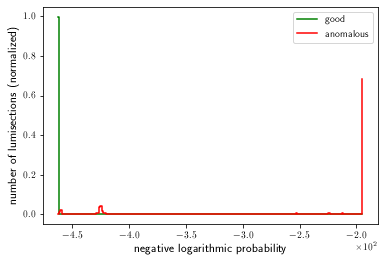

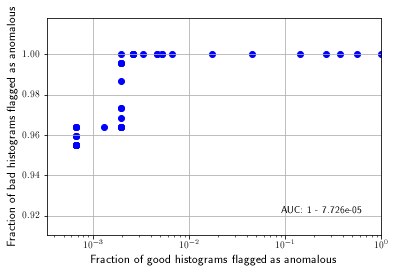

Selected logprob threshold of 452.9219947622614
Accuracy: 0.9772471300745601
Precision: 0.9993066782738466
Recall: 0.9551569506726457
F-Measure: 0.9636720258468713


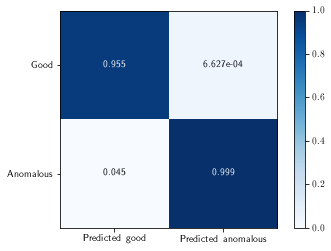

In [64]:
logprob_threshold = evaluate_autoencoders_combined(logprob_good, logprob_bad, biasFactor)